In [26]:
import sys
sys.path.insert(0, './utils')

import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

from game import *
from tools import *
from tqdm import trange, tqdm
from scipy import interpolate

# Let's play one against the other 

In [2]:
cards = ["Ace", "King", "Queen", "Jack", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
signs = ["Club", "Diamond", "Heart", "Spade"]
initialW = 100
n = 7
m = 11
it = int(5*1e3)
lr = .5
exp = 1e-2
step = 1e-5
alpha = 3.
decay = 1.
maxBet = 10
retreat = 1
parameters = np.ones((2*(m-n)+1, maxBet, 2))*1e-5

In [3]:
class Game(): 
    
    def __init__(self, firstPlayer, secondPlayer):
        self.cards = 4*list(range(n, m+1))
        self.firstPlayer = firstPlayer
        self.secondPlayer = secondPlayer
        self.turn = random.randint(0, 1)
        
    def deal(self):
        random.shuffle(self.cards)
        self.turn = 1 - self.turn
        self.firstPlayer.hand = [self.cards[0], self.cards[2]]
        self.firstPlayer.sum = sum(self.firstPlayer.hand)
        self.secondPlayer.hand = [self.cards[1], self.cards[3]]
        self.secondPlayer.sum = sum(self.secondPlayer.hand)
        
    def reset(self):
        self.secondPlayer.reset()
        self.firstPlayer.reset()
        self.turn = random.randint(0, 1)
        
    def learn(self, rounds = 10):

        score = 0
        for _ in range(rounds):
            self.reset()
            while self.firstPlayer.worth * self.secondPlayer.worth > 0:
                self.deal()
                play(self.firstPlayer, self.secondPlayer, self.turn)
            score += (self.firstPlayer.worth > 0)
            
        return score
    
    def human(self, results = True):

        self.reset()
        while self.firstPlayer.worth * self.secondPlayer.worth > 0:
            self.deal()
            play(self.firstPlayer, self.secondPlayer, self.turn)
            
            if results:
                print("-------------------------")
                print("The {0} hand and last action were: {1}-{2}".format(self.secondPlayer.name, self.secondPlayer.hand, self.secondPlayer.action))
                print("-------------------------")
                print("The {0} hand and last action were: {1}-{2}".format(self.firstPlayer.name, self.firstPlayer.hand, self.firstPlayer.action))
                print("-------------------------")
                print("Current Net Worth of {0}: {1} - Current Net Worth of {2}: {3}".format(self.firstPlayer.name, self.firstPlayer.worth, self.secondPlayer.name, self.secondPlayer.worth))
                print("=========================")
            
        if self.secondPlayer.worth > 0:
            print("\n And the final winner is {0}! :)".format(self.secondPlayer.name))
        else:
            print("\n And the final winner is {0}! :>".format(self.firstPlayer.name))

In [44]:
class Player:
    
    def __init__(self, name = "Player", lr = lr, exp = exp):
        self.trainable = True
        self.worth = initialW
        self.statDict = {}
        self.lr = lr
        self.exp = exp
        self.name = name
        self.maxBet = maxBet
        
    def reset(self):
        self.worth = initialW
        
    def chooseAction(self, actions, advAction):
        
        if random.random() < self.exp:
            return random.choice(actions)

        action = None
        vmax = - 1e10
        state = str(self.sum) + "-" + str(advAction) + "-" + str(self.lastAction)
        for act in actions:
            current = 0 if self.statDict.get(state) is None or self.statDict.get(state).get(str(act)) is None else self.statDict.get(state).get(str(act))
            if vmax < current:
                vmax = current
                action = act
                    
            return action
        
    def update(self, adverser):
        if self.trainable:
            if adverser.action > 0:
                state = str(self.sum) + "-" + str(adverser.lastAction) + "-" + str(self.lastAction)
                
                if self.statDict.get(state) is None:
                    self.statDict[state] = {}
                if self.statDict.get(state).get(str(self.action)) is None:
                    self.statDict[state][str(self.action)] = 0

                if self.action == adverser.action:
                    if self.sum > adverser.sum:
                        self.statDict[state][str(self.action)] += self.lr*(  self.action - self.statDict[state][str(self.action)])
                    elif self.sum < adverser.sum:
                        self.worth -= self.action
                        self.statDict[state][str(self.action)] += self.lr*(- self.action - self.statDict[state][str(self.action)])

                elif self.action == 0:
                    if self.lastAction is None:
                        self.worth -= retreat
                        self.statDict[state][str(self.action)] += self.lr*(- retreat - self.statDict[state][str(self.action)])

                    else:
                        self.worth -= self.lastAction
                        self.statDict[state][str(self.action)] += self.lr*(- self.lastAction - self.statDict[state][str(self.action)])
        
        else:
            if self.action == adverser.action and self.sum < adverser.sum:
                self.worth -= self.action
            elif self.action == 0:
                if self.lastAction is None:
                    self.worth -= retreat
                else:
                    self.worth -= self.lastAction

In [5]:
class HumanPlayer(Player):
    
    def __init__(self, name = "HumanPlayer"):
        Player.__init__(self)
        self.name = name
        
    def chooseAction(self, actions, advAction):
        print("State: ", self.hand)
        
        if advAction is None: 
            pass
        else:
            print("Adverser played: ", advAction)
            
        action = int(input("Input your action: ")) 
        
        while action not in actions:
            print("Try a number in ", actions)
            action = int(input("Input your action: "))  
            
        return action
    
    def update(self, adverser):
        if self.action == adverser.action and self.sum < adverser.sum:
            self.worth -= self.action
        elif self.action == 0:
            if self.lastAction is None:
                self.worth -= retreat
            else:
                self.worth -= self.lastAction

In [6]:
## TO TRAIN A BASIC SIMPLE MODEL YOU CAN USE, IT IS NOT VERY SMART
# firstPlayer = Player()
# secondPlayer = Player()
# cards = Cards(firstPlayer, secondPlayer)
# cards.train(it)

In [7]:
# TO PLAY AGAINST A VIRTUAL PLAYER, YOU CAN UNCOMMENT THE FOLLOWING LINES AFTER TRAINING THE AGENT
# firstPlayer.reset()
# human = HumanPlayer()
# cards = Cards(firstPlayer, human)
# cards.human()

In [8]:
class GreedyPlayer(Player):
    
    def __init__(self, name = "GreedyPlayer"):
        Player.__init__(self)
        self.name = name
        
    def chooseAction(self, actions, advAction):
        if advAction is None:
            return random.choice(actions)
        if self.sum > m + n:
            return advAction
        return 0
    
    def update(self, adverser):
        if self.action == adverser.action and self.sum < adverser.sum:
            self.worth -= self.action
        elif self.action == 0:
            if self.lastAction is None:
                self.worth -= retreat
            else:
                self.worth -= self.lastAction

In [9]:
## TO TRAIN A BASIC SIMPLE MODEL YOU CAN USE, IT IS NOT VERY SMART
# firstPlayer = GreedyPlayer()
# secondPlayer = Player()
# cards = Cards(firstPlayer, secondPlayer)
# cards.train(it)

In [10]:
# TO PLAY AGAINST A VIRTUAL PLAYER, YOU CAN UNCOMMENT THE FOLLOWING LINES AFTER TRAINING THE AGENT
# human = HumanPlayer()
# cards = Cards(firstPlayer, human)
# cards.human()

# Thompson Sampling

In [11]:
class ThompsonSampling(Player):
    def __init__(self, parameters = parameters, name = "Thompson", exp = exp):
        Player.__init__(self)
        self.exp = exp
        self.step = step
        self.name = name
        self.parameters = parameters
        self.nbDraws = np.zeros((2*(m-n) + 1, maxBet + 1))
        self.cumRewards = np.zeros((2*(m-n) + 1, maxBet + 1))

    def chooseAction(self, actions, advAction):
        if advAction is None:
            expression = np.zeros(maxBet + 1)
            for i in range(len(actions)):
                act = actions[i]
                expression[act] = np.random.beta(self.parameters[self.sum - 2*n, act - 1, 0] + self.cumRewards[self.sum-2*n, act],
                                             self.parameters[self.sum - 2*n, act - 1, 1] + self.nbDraws[self.sum-2*n, act] - self.cumRewards[self.sum-2*n, act])
            return random.choice(actions)
        
        elif random.random() < self.exp:
            return random.choice(actions)
        
        """
        hand, action = state.split("-")
        cards = [int(card) for card in hand[1:-1].split(",")]
        action = int(action)
        
        estimated = random.betavariate(self.parameters[action-1][0], self.parameters[action-1][1])
        estimated = 2*n + int(2*(m-n)*estimated)
    
        if sum(cards) >= estimated: 
            return int(action)
        return 0 
        """
        action = advAction
        
        expression = np.zeros(maxBet + 1)
        for i in range(len(actions)):
            act = actions[i]
            expression[act] = np.random.beta(self.parameters[self.sum - 2*n, action - 1, 0] + self.cumRewards[self.sum-2*n, act],
                                             self.parameters[self.sum - 2*n, action - 1, 1] + self.nbDraws[self.sum-2*n, act] - self.cumRewards[self.sum-2*n, act])
        return randmax(expression)
        
    def update(self, adverser):
        if self.trainable:
            if self.action == adverser.action:
                if self.sum > adverser.sum:
                    self.parameters[self.sum - 2*n, adverser.action - 1, 0] += self.step
                elif self.sum < adverser.sum:
                    self.worth -= adverser.action
                    self.parameters[self.sum - 2*n, adverser.action - 1, 1] += self.step
                    
            elif self.action == 0:
                if self.lastAction is None:
                    self.worth -= retreat
                else:
                    self.worth -= self.lastAction
                    self.parameters[self.sum - 2*n, adverser.action - 1, 1] += self.step
            
        else:
            if self.action == adverser.action and self.sum < adverser.sum:
                self.worth -= self.action
            elif self.action == 0:
                if self.lastAction is None:
                    self.worth -= retreat
                else:
                    self.worth -= self.lastAction

In [12]:
# firstPlayer = ThompsonSampling()
# secondPlayer = Player()
# cards = Cards(firstPlayer, secondPlayer)
# cards.train(it, bandit = True)

In [13]:
# cards = Cards(firstPlayer, HumanPlayer())
# cards.human(human = True, bandit = True, result = True)

# UCB Sampling

In [14]:
class UCBSampling(Player):
    def __init__(self, alpha = alpha, name = "UCB", exp = exp):
        Player.__init__(self)
        self.exp = exp
        self.name = name
        self.alpha = alpha
        self.nbDraws = np.zeros((2*(m-n) + 1, maxBet + 1))
        self.cumRewards = np.zeros((2*(m-n) + 1, maxBet + 1))

    def chooseAction(self, actions, advAction):
        
        if random.random() < self.exp:
            final = random.choice(actions)
            self.cumRewards[self.sum-2*n, final] += 1
            return final
        
        expression = np.zeros(maxBet + 1)
        calls = np.sum(self.nbDraws)
        
        for i in range(len(actions)):
            act = actions[i]
            if self.nbDraws[self.sum-2*n, act] < 1: expression[act] = np.inf
            else:
                expression[act] = self.cumRewards[self.sum-2*n, act]/self.nbDraws[self.sum-2*n, act] + np.sqrt((self.alpha*np.log(calls+1))/self.nbDraws[self.sum-2*n, act])
        
        final = randmax(expression)
        self.cumRewards[self.sum-2*n, final] += 1
        return final
        
    def update(self, adverser): 
        if self.trainable:
            if self.action == adverser.action:
                if self.sum > adverser.sum:
                    self.cumRewards[self.sum-2*n, adverser.action] += adverser.action
                elif self.sum < adverser.sum:
                    self.worth -= adverser.action
                    self.cumRewards[self.sum-2*n, adverser.action] -= adverser.action
            elif self.action == 0:
                if self.lastAction is None:
                    self.worth -= retreat
                else:
                    self.worth -= self.lastAction
                self.cumRewards[self.sum-2*n, adverser.action] -= adverser.action
        else:
            if self.action == adverser.action and self.sum < adverser.sum:
                self.worth -= adverser.action
            elif self.action == 0:
                if self.lastAction is None:
                    self.worth -= retreat
                else:
                    self.worth -= self.lastAction

In [15]:
# firstPlayer = UCB()
# secondPlayer = Player()
# cards = Cards(firstPlayer, secondPlayer)
# cards.train(it, bandit = True)

In [16]:
# cards = Cards(firstPlayer, HumanPlayer())
# cards.human(human = True, bandit = True, result = True)

# Who's better

## TRAIN

In [17]:
fPlayer = Player(lr = .1, exp = .1)
sPlayer = Player(lr = .9, exp = 0)
game = Game(fPlayer, sPlayer)
game.learn(it)

2454

In [18]:
greedyPlayer = GreedyPlayer()
game = Game(fPlayer, greedyPlayer)
game.learn(it)

3114

In [19]:
UCBPlayer = UCBSampling()
fPlayer.trainable = False
game = Game(fPlayer, UCBPlayer)
game.learn(it)

2767

In [20]:
ThompsonPlayer = ThompsonSampling()
fPlayer.trainable = False
game = Game(fPlayer, ThompsonPlayer)
game.learn(it)

2693

## EVAL

In [47]:
learning = []
batch = 5000
sPlayer.trainable = False
fPlayer.exp = 1e-2
fPlayer.lr = .01
for i in trange(100):
    game = Game(fPlayer, sPlayer)
    learning.append(game.learn(batch))

100%|█████████████████████████████████████████| 100/100 [12:38<00:00,  7.58s/it]


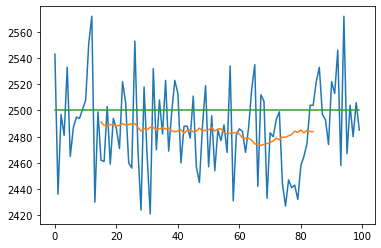

In [48]:
x, y = smooth(learning, 30)
plt.plot(learning)
plt.plot(x, y)
plt.plot(np.ones(len(learning))*batch//2)

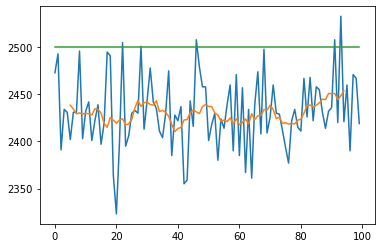

In [35]:
x, y = smooth(learning, 10)
plt.plot(learning)
plt.plot(x, y)
plt.plot(np.ones(len(learning))*batch//2)

## INFO

In [43]:
fPlayer.statDict

{'19-1-None': {'8': -2.3917184562761618,
  '6': -1.692658991424308,
  '2': -1.0630423398400273,
  '5': -0.7467025193230497,
  '9': -2.277023939147467,
  '4': -1.6955457258639872,
  '3': -0.9220251561507193,
  '10': 0.8043002618828559,
  '7': -1.7469481520873131},
 '18-None-None': {'1': -0.8300952743174848,
  '8': 0.4049035538543184,
  '6': 2.66431219962462,
  '9': -0.5578858036265109,
  '10': -2.567635354149072,
  '7': -1.9510674503152285,
  '2': 0.3332044200289275,
  '3': -0.049712339692222385,
  '0': -0.9999999999999996,
  '5': -0.5999529541397915,
  '4': -2.384792054051789},
 '17-None-None': {'1': -0.9487721291732822,
  '2': -0.27127515690652887,
  '5': -3.5312408003485904,
  '8': -4.176838986293783,
  '3': -1.8940713200606005,
  '9': -5.079079123485455,
  '6': -3.4045450777347233,
  '10': -6.752863503996965,
  '4': -0.4192905281129612,
  '0': -0.9999999999999996,
  '7': -4.290901621126477},
 '14-None-None': {'1': -0.9999999999999996,
  '5': -4.9999999999999964,
  '8': -7.9999999999

# Who's better Zayed or the computer ?

In [23]:
# game = Game(GreedyPlayer(), HumanPlayer())
# game.human(results = True)